In [ ]:
from google.colab import drive

drive.flush_and_unmount()

In [ ]:
from google.colab import drive
import os

# Check if the drive is already mounted
if not os.path.exists('/content/drive'):
  # Now mount the drive
  drive.mount('/content/drive')
  print('Drive mounted')
else:
  print('Drive is already mounted')

In [ ]:
!ls /content/drive/MyDrive/Capstone/dataset

In [ ]:
import os
import subprocess

# Set the dataset path in your Google Drive
dataset_path = '/content/drive/MyDrive/Capstone/dataset/2805-3319'

# Resolve symbolic link if it is one
if os.path.islink(dataset_path):
    dataset_path = os.readlink(dataset_path)

output_path = '/content/drive/MyDrive/Capstone/output/2805-3319'  # Output directory for audio/video files

# Create output directories for audio and video
video_output_path = os.path.join(output_path, 'video')
audio_output_path = os.path.join(output_path, 'audio')

os.makedirs(video_output_path, exist_ok=True)
os.makedirs(audio_output_path, exist_ok=True)

# Get the list of MP4 files
mp4_files = [f for f in sorted(os.listdir(dataset_path)) if f.endswith('.mp4')]

# Loop through the files and split audio and video
for file in mp4_files:
    input_file = os.path.join(dataset_path, file)

    # Create separate output files for audio and video within their respective folders
    video_output = os.path.join(video_output_path, f"{os.path.splitext(file)[0]}_video.mp4")
    audio_output = os.path.join(audio_output_path, f"{os.path.splitext(file)[0]}_audio.wav")

    # Check the pixel format of the input video
    check_command = [
        "ffprobe",
        "-v", "error",
        "-select_streams", "v:0",
        "-show_entries", "stream=pix_fmt",
        "-of", "default=noprint_wrappers=1:nokey=1",
        input_file
    ]
    pix_fmt = subprocess.run(check_command, stdout=subprocess.PIPE, stderr=subprocess.PIPE).stdout.decode('utf-8').strip()

    # Choose the FFmpeg command based on bit depth
    if '10' in pix_fmt:  # 10-bit video
        command = [
            "ffmpeg",
            "-i", input_file,
            "-c:v", "libx264", "-crf", "23", "-pix_fmt", "yuv420p10le",
            "-an", video_output,
            "-vn", "-acodec", "pcm_s16le", "-ar", "44100", "-ac", "2", audio_output
        ]
    else:  # 8-bit video
        command = [
            "ffmpeg",
            "-hwaccel", "cuda",
            "-i", input_file,
            "-c:v", "h264_nvenc", "-preset", "fast",
            "-an", video_output,
            "-vn", "-acodec", "pcm_s16le", "-ar", "44100", "-ac", "2", audio_output
        ]

    print(f"Processing: {file}")

    # Run the FFmpeg command and capture output
    process = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    # Check for any errors
    if process.returncode == 0:
        print(f"Successfully split video and audio for: {file}")
    else:
        print(f"Error splitting {file}: {process.stderr.decode('utf-8')}")

print("Splitting completed!")

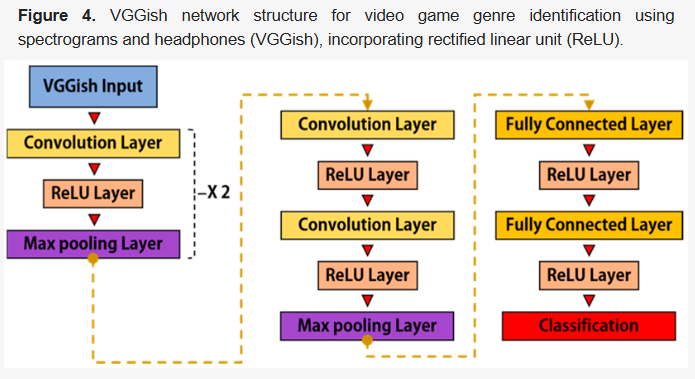

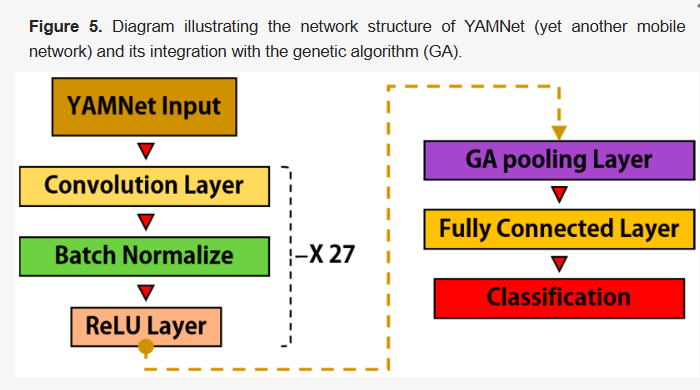

In [ ]:
!ls /content/drive/MyDrive/Capstone/output/1-1004/

In [ ]:
!pip install soundfile --upgrade

In [ ]:
!ls /content/drive/MyDrive/Capstone/output/1005-2004/features/audio

In [ ]:
import os
import numpy as np
import tensorflow_hub as hub
import soundfile as sf
import tensorflow as tf

# Load YAMNet model from TensorFlow Hub
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

# Define audio input and output paths
audio_input_path = '/content/drive/MyDrive/Capstone/output/1005-2004/audio'
audio_features_output_path = '/content/drive/MyDrive/Capstone/output/1005-2004/features/audio'
os.makedirs(audio_features_output_path, exist_ok=True)

# Function to extract and save audio features
def extract_and_save_audio_features(file_path, output_path):
    """
    Extracts audio features from a WAV file using YAMNet and saves them to a .npy file.
    """
    try:
        # Load audio waveform and sample rate
        waveform, sample_rate = sf.read(file_path)

        # Check if the waveform is stereo and convert to mono if necessary
        if waveform.ndim == 2:  # Stereo
            waveform = np.mean(waveform, axis=1)  # Convert to mono

        # Extract audio embeddings from YAMNet in smaller batches
        # to reduce GPU memory usage
        embeddings_list = []
        batch_size = 1024  # Adjust batch size as needed
        for i in range(0, len(waveform), batch_size):
            batch_waveform = waveform[i : i + batch_size]
            # Wrap batch_waveform in a tf.Tensor for compatibility with yamnet_model
            batch_waveform_tensor = tf.convert_to_tensor(batch_waveform, dtype=tf.float32)

            _, embeddings, _ = yamnet_model(batch_waveform_tensor)
            embeddings_list.append(embeddings.numpy())

        # Concatenate embeddings from all batches
        embeddings = np.concatenate(embeddings_list, axis=0)

        # Save the embeddings as a .npy file
        output_file = os.path.join(output_path, f"{os.path.basename(file_path).replace('.wav', '')}_features.npy")
        np.save(output_file, embeddings)  # Save as .npy
        print(f"Saved audio features to {output_file}")

    except sf.LibsndfileError as e:
        print(f"Error processing {file_path}: {e}")
        # You might want to log the error or skip this file
        # and continue with the rest of the files.


# Iterate through audio files and extract features
for audio_file in os.listdir(audio_input_path):
    if audio_file.endswith('.wav'):
        file_path = os.path.join(audio_input_path, audio_file)
        extract_and_save_audio_features(file_path, audio_features_output_path)

print("Audio feature extraction completed!")

In [ ]:
!ls '/content/drive/MyDrive/Capstone/output/test/features/'

In [ ]:
import os
import numpy as np

# Define the path to the audio features
audio_features_output_path = '/content/drive/MyDrive/Capstone/output/test/features/video_x3d'

# Iterate through the feature files and print their shapes
for feature_file in os.listdir(audio_features_output_path):
    if feature_file.endswith('_features.npy'):
        file_path = os.path.join(audio_features_output_path, feature_file)
        embeddings = np.load(file_path)  # Load the embeddings from the .npy file
        print(f"Shape of embeddings for {feature_file}: {embeddings.shape}")


In [ ]:
!pip install --upgrade torch torchvision

In [ ]:
!pip install fvcore iopath pytorchvideo

In [ ]:
!ls /content/drive/MyDrive/Capstone/output/test/video

In [ ]:
!pip install pytorchvideo

In [ ]:
!pip install torch-vision

In [ ]:
!pip install --upgrade torch torchvision
!pip install fvcore iopath pytorchvideo

In [ ]:
!ls /content/drive/MyDrive/Capstone/xd-i3d-features

In [ ]:
import os
import numpy as np

# Define the path to the audio features
audio_features_output_path = '/content/drive/MyDrive/Capstone/xd-i3d-features/FlowTest'
file_count = 0
# Iterate through the feature files and print their shapes
for feature_file in os.listdir(audio_features_output_path):
    if feature_file.endswith('.npy'):
        file_path = os.path.join(audio_features_output_path, feature_file)
        embeddings = np.load(file_path)  # Load the embeddings from the .npy file
        print(f"Shape of embeddings for {feature_file}: {embeddings.shape}")
        file_count += 1
        if file_count >= 10:
            break  # Stop after processing 10 files


In [ ]:
!pip install fvcore

In [ ]:
import os
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import math

# Load X3D model (pretrained on Kinetics-400)
model = torch.hub.load('facebookresearch/pytorchvideo', 'x3d_m', pretrained=True)
model.eval()

# Remove the final classification head to extract embeddings
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])  # Outputs 2048-dim features

# Transformations: Resize, Normalize (aligned with X3D requirements)
frame_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),  # X3D typically uses 256x256
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.45, 0.45, 0.45], std=[0.225, 0.225, 0.225])  # X3D normalization
])

class SlidingWindowVideoDataset(Dataset):
    """
    Splits the video into windows of 16 frames each at 24 FPS.
    """
    def __init__(self, video_path, frame_transform=None, fps=24, window_size=16):
        self.video_path = video_path
        self.frame_transform = frame_transform
        self.target_fps = fps
        self.window_size = window_size
        self.windows = []  # Stores windows of 16 frames each
        self._create_windows()

    def _create_windows(self):
        cap = cv2.VideoCapture(self.video_path)
        original_fps = cap.get(cv2.CAP_PROP_FPS)
        if original_fps <= 0:
            print(f"Warning: Failed to retrieve FPS for {self.video_path}. Defaulting to 30 FPS.")
            original_fps = 30.0

        frames_rgb = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames_rgb.append(frame)
        cap.release()

        # Normalize frame rate to 24 FPS
        ratio = original_fps / self.target_fps
        normalized_frames = [frames_rgb[int(i * ratio)] for i in range(int(len(frames_rgb) / ratio))]

        # Create sliding windows of size 16 frames
        start_idx = 0
        while start_idx + self.window_size <= len(normalized_frames):
            window_frames = normalized_frames[start_idx:start_idx + self.window_size]
            self.windows.append(window_frames)
            start_idx += self.window_size  # No overlap, stride=16

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        window_frames = self.windows[idx]
        transformed_frames = [self.frame_transform(f) for f in window_frames]
        frames_tensor = torch.stack(transformed_frames)
        frames_tensor = frames_tensor.permute(1, 0, 2, 3).unsqueeze(0)  # Shape: (1, C, T, H, W)
        return frames_tensor, idx

def extract_x3d_features(video_path, output_dir, max_chunks=4):
    """
    Extracts X3D features for each window in the video and splits them into up to 4 .npy files.
    Each .npy file contains features for a chunk of windows, with shape (num_windows_in_chunk, 2048).
    """
    os.makedirs(output_dir, exist_ok=True)
    dataset = SlidingWindowVideoDataset(video_path, frame_transform=frame_transform, fps=24, window_size=16)
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    total_windows = len(dataset)

    # Divide windows into up to `max_chunks` chunks
    windows_per_chunk = math.ceil(total_windows / max_chunks) if total_windows > 0 else 1
    chunk_indices = list(range(0, total_windows, windows_per_chunk))
    if len(chunk_indices) > max_chunks:
        chunk_indices = chunk_indices[:max_chunks]

    for chunk_idx, start_idx in enumerate(chunk_indices):
        # Collect features for this chunk
        chunk_embeddings = []
        end_idx = min(start_idx + windows_per_chunk, total_windows)
        for i in range(start_idx, end_idx):
            frames_tensor, _ = dataset[i]
            with torch.no_grad():
                features = feature_extractor(frames_tensor)  # Output: (1, 2048, ...)
                features = features.squeeze().cpu().numpy()  # Shape: (2048,)
            chunk_embeddings.append(features)

        if chunk_embeddings:  # Only save if there are embeddings
            # Stack features into a matrix: (num_windows_in_chunk, 2048)
            embeddings_matrix = np.vstack(chunk_embeddings)  # Shape: (N, 2048)
            # Save as .npy file with chunk index starting from 1
            out_path = os.path.join(output_dir, f"{video_name}_{chunk_idx + 1}.npy")
            np.save(out_path, embeddings_matrix)
            print(f"Saved chunk {chunk_idx + 1} to {out_path} with shape {embeddings_matrix.shape}")

if __name__ == "__main__":
    video_folder = "/content/drive/MyDrive/Capstone/output/test/video"
    output_folder = "/content/drive/MyDrive/Capstone/output/test/features/video_x3d"

    os.makedirs(output_folder, exist_ok=True)
    for video_file in os.listdir(video_folder):
        if video_file.endswith(".mp4"):
            video_path = os.path.join(video_folder, video_file)
            print(f"Processing {video_file} and extracting X3D features...")
            extract_x3d_features(video_path, output_folder, max_chunks=4)

    print("Feature extraction completed!")

In [ ]:
import os
import cv2
import numpy as np
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import math

# Load X3D model (pretrained on Kinetics-400)
model = torch.hub.load('facebookresearch/pytorchvideo', 'x3d_m', pretrained=True)
model.eval()

# Remove the final classification head to extract embeddings
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])  # Outputs 2048-dim features

# Transformations: Resize, Normalize (aligned with X3D requirements)
frame_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((256, 256)),  # X3D typically uses 256x256
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.45, 0.45, 0.45], std=[0.225, 0.225, 0.225])  # X3D normalization
])

class SlidingWindowVideoDataset(Dataset):
    """
    Splits the video into windows of 16 frames each at 24 FPS.
    """
    def __init__(self, video_path, frame_transform=None, fps=24, window_size=16, stride=16):
        self.video_path = video_path
        self.frame_transform = frame_transform
        self.target_fps = fps
        self.window_size = window_size
        self.stride = stride
        self.windows = []  # Stores windows of 16 frames each
        self.total_frames = 0
        self._create_windows()

    def _create_windows(self):
        cap = cv2.VideoCapture(self.video_path)
        original_fps = cap.get(cv2.CAP_PROP_FPS)
        if original_fps <= 0:
            print(f"Warning: Failed to retrieve FPS for {self.video_path}. Defaulting to 30 FPS.")
            original_fps = 30.0

        frames_rgb = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frames_rgb.append(frame)
        cap.release()

        self.total_frames = len(frames_rgb)
        duration_sec = self.total_frames / original_fps
        print(f"Video {self.video_path}: {self.total_frames} frames at {original_fps} FPS, duration {duration_sec:.2f} seconds")

        # Normalize frame rate to 24 FPS
        ratio = original_fps / self.target_fps
        normalized_frames = [frames_rgb[int(i * ratio)] for i in range(int(len(frames_rgb) / ratio))]
        print(f"After FPS normalization to {self.target_fps} FPS: {len(normalized_frames)} frames")

        # Create sliding windows of size 16 frames
        start_idx = 0
        while start_idx + self.window_size <= len(normalized_frames):
            window_frames = normalized_frames[start_idx:start_idx + self.window_size]
            self.windows.append(window_frames)
            start_idx += self.stride
        print(f"Created {len(self.windows)} windows with window_size={self.window_size}, stride={self.stride}")

    def __len__(self):
        return len(self.windows)

    def __getitem__(self, idx):
        window_frames = self.windows[idx]
        transformed_frames = [self.frame_transform(f) for f in window_frames]
        frames_tensor = torch.stack(transformed_frames)  # Shape: (16, 3, 256, 256)
        frames_tensor = frames_tensor.permute(1, 0, 2, 3).unsqueeze(0)  # Shape: (1, 3, 16, 256, 256)
        return frames_tensor, idx

def extract_x3d_features(video_path, output_dir, max_chunks=4, stride=16):
    """
    Extracts X3D features for each window in the video and splits them into up to 4 .npy files.
    Each .npy file contains features for a chunk of windows, with shape (num_windows_in_chunk, 2048).
    """
    os.makedirs(output_dir, exist_ok=True)
    dataset = SlidingWindowVideoDataset(video_path, frame_transform=frame_transform, fps=24, window_size=16, stride=stride)
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    total_windows = len(dataset)

    # Divide windows into up to `max_chunks` chunks
    windows_per_chunk = math.ceil(total_windows / max_chunks) if total_windows > 0 else 1
    chunk_indices = list(range(0, total_windows, windows_per_chunk))
    if len(chunk_indices) > max_chunks:
        chunk_indices = chunk_indices[:max_chunks]
    print(f"Total windows: {total_windows}, splitting into {len(chunk_indices)} chunks, ~{windows_per_chunk} windows per chunk")

    for chunk_idx, start_idx in enumerate(chunk_indices):
        # Collect features for this chunk
        chunk_embeddings = []
        end_idx = min(start_idx + windows_per_chunk, total_windows)
        for i in range(start_idx, end_idx):
            frames_tensor, _ = dataset[i]  # Shape: (1, 3, 16, 256, 256)
            print(f"Window {i+1}/{total_windows}, input shape: {frames_tensor.shape}")
            with torch.no_grad():
                features = feature_extractor(frames_tensor)  # Output: (1, 2048, 1, 1, 1)
                features = features.squeeze()  # Shape: (2048,)
                if features.ndim > 1:
                    features = features.flatten()  # Ensure 1D vector
                print(f"Feature shape: {features.shape}")
            chunk_embeddings.append(features.cpu().numpy())

        if chunk_embeddings:
            # Stack features into a matrix: (num_windows_in_chunk, 2048)
            embeddings_matrix = np.vstack(chunk_embeddings)  # Shape: (N, 2048)
            # Handle file naming
            try:
                parts = video_name.split('__#')
                movie_name = parts[0]
                timestamp_label = parts[1].rsplit('_video', 1)[0]
                out_filename = f"{movie_name}__#{timestamp_label}_video_{chunk_idx + 1}.npy"
            except:
                out_filename = f"{video_name}_{chunk_idx + 1}.npy"
            out_path = os.path.join(output_dir, out_filename)
            np.save(out_path, embeddings_matrix)
            print(f"Saved chunk {chunk_idx + 1} to {out_path} with shape {embeddings_matrix.shape}")

if __name__ == "__main__":
    video_folder = "/content/drive/MyDrive/Capstone/output/test/video"
    output_folder = "/content/drive/MyDrive/Capstone/output/test/features/video_x3d"

    os.makedirs(output_folder, exist_ok=True)
    for video_file in os.listdir(video_folder):
        if video_file.endswith(".mp4"):
            video_path = os.path.join(video_folder, video_file)
            print(f"Processing {video_file} and extracting X3D features...")
            extract_x3d_features(video_path, output_dir=output_folder, max_chunks=4, stride=16)

    print("Feature extraction completed!")